In [1]:
from rag.load import load_benchmark_corpus, corpus_to_texts_metadatas


benchmark, corpus = load_benchmark_corpus()
texts, metadatas = corpus_to_texts_metadatas(corpus)

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '\n', '!', '?', '.', ':', ';', ',', ' ', ''],
    chunk_size=500,
    chunk_overlap=0,
    add_start_index=True,
)

documents = text_splitter.create_documents(texts, metadatas=metadatas)

In [3]:
%matplotlib inline

import statistics

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

def show_hist(xs, title=None):
    sns.histplot(xs)
    plt.title(f'{title} (mean={statistics.mean(xs):.2f}, median={statistics.median(xs):.2f})')
    plt.show()

In [4]:
import os

target_spans = []
for test in benchmark:
    snippets = test["snippets"]
    for snippet in snippets:
        start, end = snippet["span"]
        target_spans.append((os.path.basename(snippet['file_path']), start, end))

rag_spans = []
for doc in documents:
    start = doc.metadata['start_index']
    end = start + len(doc.page_content)
    rag_spans.append((doc.metadata['source_file'], start, end))

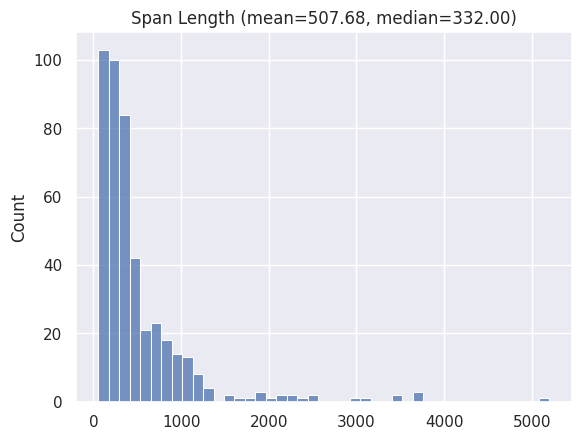

In [5]:
show_hist([end - start for _, start, end in target_spans], title='Span Length')

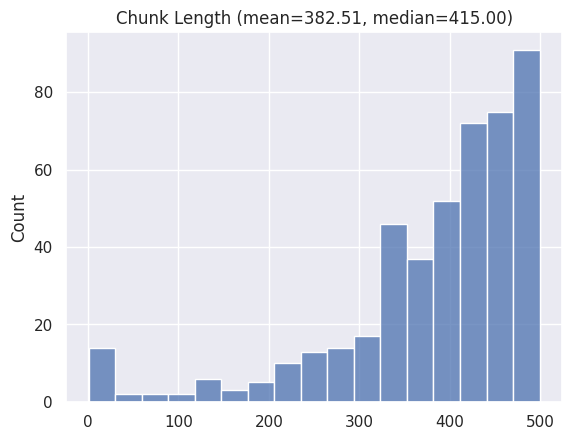

In [6]:
show_hist([end - start for _, start, end in rag_spans], title='Chunk Length')

In [7]:
from collections import Counter


overlap_counts = []
max_precisions = []
max_recall_at_1s = []
for f1, a, b in target_spans:
    
    overlap_count = 0
    max_precision = 0
    max_recall = 0
    for f2, c, d in rag_spans:
        if f1 != f2:
            continue
        if b < c or d < a:
            continue
            
        overlap_count += 1
        overlap_length = min(b, d) - max(a, c)
        max_precision = max(max_precision, overlap_length / (b - a))
        max_recall = max(max_recall, overlap_length / (d - c))
        
    overlap_counts.append(overlap_count)
    max_precisions.append(max_precision)
    max_recall_at_1s.append(max_recall)

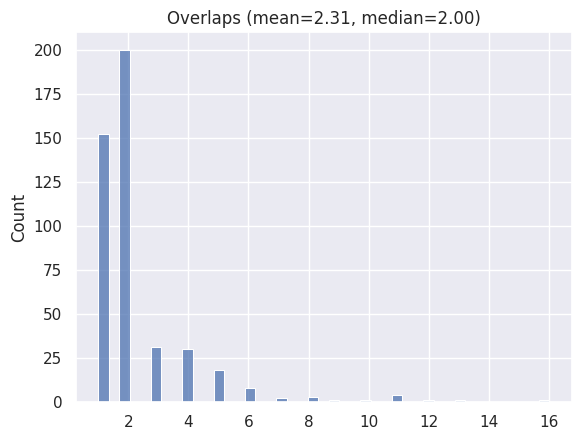

In [8]:
show_hist(overlap_counts, title="Overlaps")

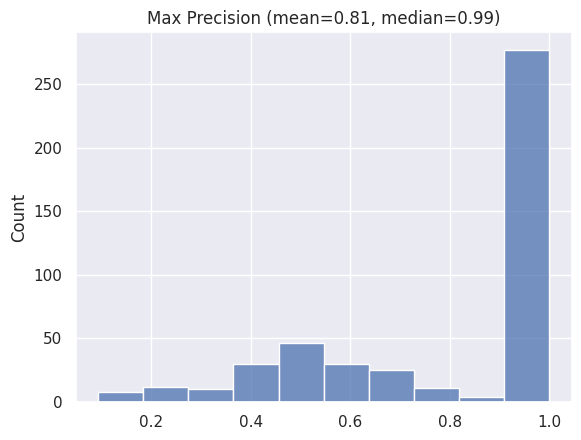

In [9]:
show_hist(max_precisions, title="Max Precision")

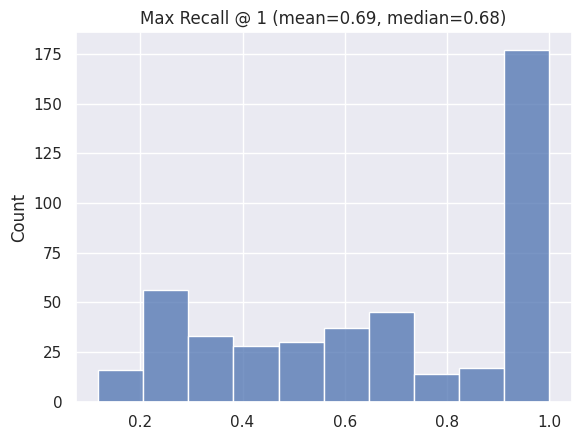

In [10]:
show_hist(max_recall_at_1s, title="Max Recall @ 1")